# UHERO API Example Notebook

This notebook demonstrates the use of the UHERO Data Portal API, and how one might use it with popular Python libraries, such as Pandas, Numpy, and Matplotlib

In [1]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import date
import matplotlib.ticker as ticker
from pprint import pprint

In [2]:
# Bearer token as API Key
headers = {
    "Authorization": "<YOUR_API_KEY>"
}

# UHERO API --> valid id's can be found on the UHERO data portal
url = "https://api.uhero.hawaii.edu/v1/package/series?u=uhero&id=153621"

In [3]:
# Call the API, use the headers, and format as json
r = requests.get(url, headers=headers)
json_data = r.json()

if r.status_code == 200:
    print('Success!')
else:
    print('Error ', json_data)

Success!


In [4]:
# Transformation results holds the numerical data we are interested in
data = json_data.get('data').get('observations').get('transformationResults')

# Initialize a list to hold each dataframe, which is each transform from the UHERO API (lvl, pc1, ytd)
final_data = []
for i in range(len(data)):
    transform = data[i]['transformation']
    pandaPrep = np.column_stack([data[i]['dates'], data[i]['values']])
    df = pd.DataFrame(pandaPrep, columns = ['Date', transform])

    df.set_index('Date', drop=True, inplace=True)

    # Incoming data is a string, so we convert to float
    df[transform] = df[transform].str.replace(',','').astype('float')
    
    final_data.append(df)
    
startDate = '2015-01-01'
endDate = '2020-05-01'

# Combine all the data into one dataframe
# We call the dataframe uiData as the series we selected holds unemployment data, it can be called anything however
uiData = pd.concat(final_data, axis=1)

# Drop the rows with NaN values
uiData = uiData.dropna()

# Set the date column to be the sorting index for the dataframe
uiData['Date'] = pd.to_datetime(uiData.index)
uiData.set_index('Date',drop=True,inplace=True)
uiData.sort_index(inplace=True)

# Truncate the data based on start/end date
uiData = uiData[startDate:endDate]
uiData = uiData.iloc[:,:5]

pprint(uiData)

             lvl   pc1   ytd
Date                        
2015-01-01   4.4  -0.8  -0.8
2015-02-01   4.3  -1.0  -0.9
2015-03-01   4.2  -0.8  -0.9
2015-04-01   4.1  -0.7  -0.8
2015-05-01   3.9  -0.7  -0.8
...          ...   ...   ...
2020-01-01   3.0   0.1   0.1
2020-02-01   2.8   0.1   0.1
2020-03-01   2.3  -0.5  -0.1
2020-04-01  33.0  30.4   7.5
2020-05-01  31.5  29.1  11.8

[65 rows x 3 columns]


In [7]:
# Plot the data
# args: dataframe, str(title), str(ylabel)
def plot_data(dataframe, title, ylabel):
    plt.style.use('fivethirtyeight')
    # Creating the Visualization
    plot = dataframe.plot(figsize=(12,8), 
                      color='#045275', 
                      linewidth=5, 
                      legend=False)
    plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plot.grid(color='#d4d4d4')
    plot.set_xlabel('Date')
    plot.set_ylabel(ylabel)

    # Adding Labels
    plot.set_title(title)
    # Todo: pull source info from the API automagically 
    plot.text(x = dataframe.index[1], 
              y = -5,
              s = 'Source: UHERO Data Portal', 
              fontsize = 10)

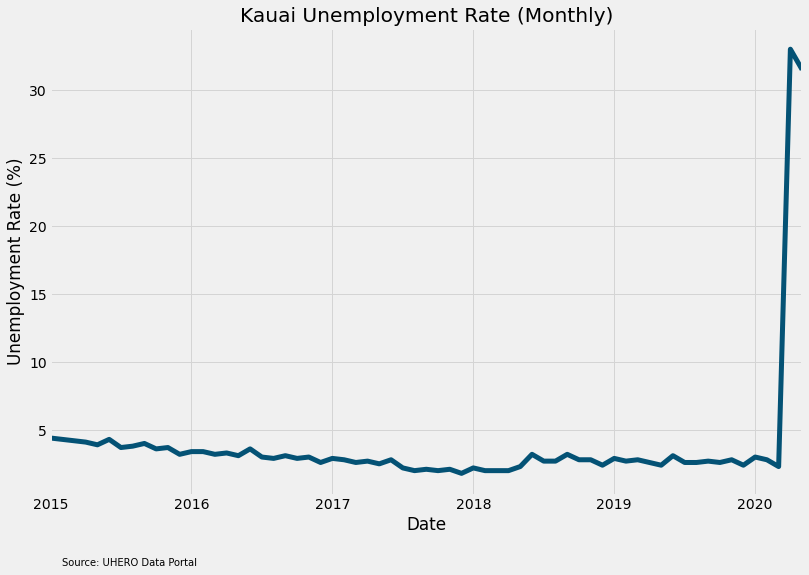

In [9]:
plot_data(uiData['lvl'], title='Kauai Unemployment Rate (Monthly)', ylabel='Unemployment Rate (%)')